NOTE: This file is used to calculate the instantaneous exponential growth rate for the three replicates of 1 hr nutrient period pulsing. Saved data is then used in Fig1a.ipynb for final plotting to make manuscript figure

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize, integrate, signal

Importing Raw Experimental Data from Nguyen et al.

In [3]:
# data file produced from MatLab code
df_vol = pd.read_csv('Nguyen_Data/Fig5_volData37.csv', names=['time','vol'])

#### Fitting three points to exponential

In [4]:
# exponential growth model for fitting data

def exp_model(t, kappa):
    return V0*np.exp(kappa*t)

In [6]:
# model for fitting data

def lin_model(t, m):
    return V0 + m*t

Remove dying cells

In [7]:
# Selecting data to analyze

V_index = ['vol']
T_index = ['time']

# Cleaning Data
Vol = df_vol[V_index[0]] # specifying which replicate to analyze
# Vol = Vol.dropna() # removing nan values
# Vol_len = len(Vol)

Time = df_vol[T_index[0]]/3600 # Time, converting to hrs
# Time = Time.iloc[0:Vol_len] # Truncating time data to match length of volume data


# Fitting Data
# separate each generation, fit linear, if negative remove

timestep = Time[1] - Time[0]
n_points = len(Time)
m = np.zeros(n_points)

i=1
new_cell = 0
while i < n_points:

    # identifies indicies where division events or new cells occur
    if Time[i]-Time[i-1] < 0 or Time[i]-Time[i-1] > 1.5*timestep or Vol[i]-Vol[i-1] < -1/4*Vol[i-1]:

        t = Time[new_cell:i] - Time[new_cell]
        v = Vol[new_cell:i]
        V0 = Vol[new_cell]

        # fitting data to obtain growth rate
        par_init = 0.7 # initial parameter guess for m

        lb = -20 # lower parameter bound
        ub = 20 # upper parameter bound

        fit = optimize.curve_fit(lin_model, t, v, p0=par_init, bounds=(lb,ub))
        ans, cov = fit # unpacking paramters

        m[new_cell:i] = ans
        new_cell = i # resetting index

    i+=1


#reindexing
threshold = 0
# removing dying cells
vol_cut = Vol[m > threshold]
time_cut = Time[m > threshold]

# reindexing data after removing dying cells
Time = time_cut.reset_index()
Time = Time[T_index[0]]
Vol = vol_cut.reset_index()
Vol = Vol[V_index[0]]


# Calculates growth rate by fitting volume trajectories to exponential function
# Sliding calculation using three or five volume data points

timestep = Time[1] - Time[0]
n_points = len(Time)
kappa = np.zeros(n_points)

i=0
while i < n_points:

    # for first point after cell division or new cell, growth rate calculation done using only two points (i and i+1)
    # if i < 3 for 15-3600 because first track is decreasing, for other two use i==0
    if i < 3 or Time[i]-Time[i-1] < 0 or Time[i]-Time[i-1] > 1.5*timestep or Vol[i]-Vol[i-1] < -1/4*Vol[i-1]:
        t = Time[i:i+2] - Time[i]
        v = Vol[i:i+2]
        V0 = Vol[i]
        ignore_neg = True # if growth rate is negative, do not expand number of fitting points

    # for last point before cell division or new cell, growth rate calculation done using only two points (i-1 and i)
    elif i == n_points-1 or Time[i+1]-Time[i] < 0 or Time[i+1]-Time[i] > 1.5*timestep or Vol[i+1]-Vol[i] < -1/4*Vol[i]: 
        t = Time[i-1:i+1] - Time[i]
        v = Vol[i-1:i+1]
        V0 = Vol[i]
        ignore_neg = True

    # for all other data points, growth rate calculated using three points (i-1,i, and i+1)
    else:
        t = Time[i-1:i+2] - Time[i]
        v = Vol[i-1:i+2]
        V0 = Vol[i]


    # fitting data to obtain growth rate

    par_init = 1 # initial parameter guess for kappa

    lb = -30 # lower parameter bound
    ub = 30 # upper parameter bound

    fit = optimize.curve_fit(exp_model, t, v, p0=par_init, bounds=(lb,ub))
    ans, cov = fit # unpacking paramters

    # if fit results in negative growth rate, refits data including more points
    if ans < 0 and ignore_neg == False:

        if Time[i+2]-Time[i+1] < 0 or Time[i+2]-Time[i+1] > 1.5*timestep or Vol[i+2]-Vol[i+1] < -1/4*Vol[i+1] or Time[i-1]-Time[i-2] < 0 or Time[i-1]-Time[i-2] > 1.5*timestep or Vol[i-1]-Vol[i-2] < -1/4*Vol[i-2]:
            ignore_neg = False # resetting ignore_neg for next time loop

        else:
            t = Time[i-2:i+3] - Time[i] # now fits to 5 points
            v = Vol[i-2:i+3]
            V0 = Vol[i]
            fit = optimize.curve_fit(exp_model, t, v, p0=par_init, bounds=(lb,ub))
            ans, cov = fit # unpacking paramters

    ignore_neg = False # resetting ignore_neg for next time loop

    kappa[i] = ans
    i+=1

# Averaging growth rates from same timepoint

# converting growth rate and time values to single df
df_kappa = pd.DataFrame(kappa, columns=['Kappa']) # converting growth rate values to dataframe
df_concat = pd.concat([Time,df_kappa], axis=1, join='inner') # concatenating growth rate df with time df

# averaging growth rates from same timepoint
t_unique = pd.unique(Time)
GRates = np.zeros(len(t_unique))

i=0
for y in t_unique:

    kappas_i = df_concat.loc[(df_concat[T_index[0]] == y), ['Kappa']] # returning all growth rates for specified timepoint
    GRates[i] = np.mean(kappas_i) # calculating mean growth rate for specified timepoint
    i+=1


GRate_ave = pd.DataFrame(GRates, columns=['GRate'])
time = pd.DataFrame(t_unique, columns=['t'])

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/_2/b28clpbs6t36hp6grpxntpq40000gn/T/ipykernel_39242/894872817.py:118: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kappa[i] = ans


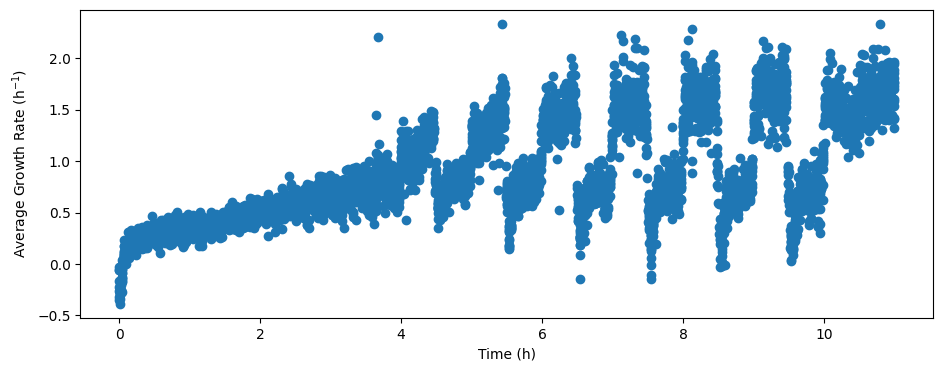

In [8]:
plt.figure(figsize=(11,4))
plt.scatter(time, GRate_ave)
plt.xlabel('Time (h)')
plt.ylabel('Average Growth Rate (h$^{-1}$)')
plt.show()

Export data

In [9]:
# concatinate to form one df
df_ave = pd.concat([time,GRate_ave], axis=1, join='inner')

# exporting data
df_ave.to_csv('Nguyen_Data/GRates_rep37.csv')